# Simulador para fila M/M/1 em Tandem

## Importações de bibliotecas

In [9]:
# gerado com apoio do chatGPT
import heapq
import random
import math
import matplotlib.pyplot as plt

# Parâmetros do simulador
arrival_rate = 0.5  # Taxa de chegada exponencial (lambda)
service_rate = 0.3  # Taxa de atendimento exponencial (mu)
simulation_time = 20000  # Tempo total de simulação

uniforme = []

exp = []

## Classe LCG

In [10]:
# Classe geradora de números randômicos
class LCG:
    def __init__(self, seed, a, c, m):
        """
        Inicializa o gerador LCG com os parâmetros fornecidos.

        Args:
            seed: Semente inicial para o gerador.
            a: Coeficiente multiplicativo.
            c: Coeficiente aditivo.
            m: Módulo.
        """
        self.seed = seed
        self.a = a
        self.c = c
        self.m = m

    def sample(self):
        """
        Amostra um valor da sequência de números pseudoaleatórios.

        Returns:
            Um número pseudoaleatório.
        """
        self.seed = (self.a * self.seed + self.c) % self.m
        uniforme.append(self.seed / self.m)
        return self.seed / self.m  # Normaliza o valor para estar entre 0 e 1

## Classe Event 

In [11]:
# Classe para representar o evento
class Event:
    def __init__(self, time, action, event_type, MM1_queue):
        self.time = time
        self.action = action
        self.event_type = event_type
        self.MM1_queue = MM1_queue

    def __lt__(self, other):
        return self.time < other.time

## Classe Queue

In [12]:
# Classe para a fila
class Queue:
    def __init__(self):
        self.buffer = []  # Buffer para armazenar os eventos

    def enqueue(self, event):
        heapq.heappush(self.buffer, event)

    def dequeue(self):
        return heapq.heappop(self.buffer)

    def is_empty(self):
        return len(self.buffer) == 0

## Classe MM1

In [13]:
class MM1:
    def __init__(self, arrival_rate, service_rate):
        self.server_idle = True
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.queue = Queue()  # Fila com buffer compartilhado
        self.queue_waiting_time = 0  # Armazena acumulado o TEMPO ESPERA FILA
        self.response_time = 0  # Armazena a acumulado o tempo de TEMPO ESPERA no Sistema
        self.num_customers_served = 0
        self.num_customers_served_from_queue = 0

## Classe Simulator

In [14]:
# Classe para o simulador
class Simulator:
    def __init__(self, arrival_rate1, service_rate1, arrival_rate2, service_rate2):
        self.current_time = 0
        self.event_queue = []

        self.MM1_1 = MM1(arrival_rate1, service_rate1)
        self.MM1_2 = MM1(arrival_rate2, service_rate2)
        self.LCG = LCG(12345, 1103515245, 12345, 2 ** 31)

    def schedule_event(self, delay, action, event_type, MM1_queue):
        event_time = self.current_time + delay
        event = Event(event_time, action, event_type, MM1_queue)
        heapq.heappush(self.event_queue, event)

    def exponential_random_variate(self, rate):
        # return -math.log(1.0 - random.random()) / rate
        resultado = -math.log(1.0 - self.LCG.sample()) / rate
        exp.append(resultado)
        return resultado

    def arrival_action(self, MM1_queue):
        interarrival_time = self.exponential_random_variate(MM1_queue.arrival_rate)
        if MM1_queue == self.MM1_1:
            self.schedule_event(interarrival_time, self.arrival_action, "Chegada", self.MM1_1)

        if MM1_queue.server_idle == True:
            service_time = self.exponential_random_variate(MM1_queue.service_rate)
            MM1_queue.response_time += service_time
            self.schedule_event(service_time, self.departure_action, "Partida", MM1_queue)
            MM1_queue.server_idle = False
            print("Inicia serviço")
        else:
            # Adiciona o evento à fila com o tempo de chegada
            event = Event(self.current_time, None, "Chegada", MM1_queue)
            print("Enfileira")
            MM1_queue.queue.enqueue(event)

    def departure_action(self, MM1_queue):
        MM1_queue.num_customers_served += 1

        if not MM1_queue.queue.is_empty():
            event = MM1_queue.queue.dequeue()
            waiting_time = self.current_time - event.time
            MM1_queue.queue_waiting_time += waiting_time
            print("Tempo {:.2f}: Tempo espera de cliente".format(MM1_queue.queue_waiting_time))
            MM1_queue.num_customers_served_from_queue += 1

            service_time = self.exponential_random_variate(MM1_queue.service_rate)
            MM1_queue.response_time += waiting_time + service_time

            self.schedule_event(service_time, self.departure_action, "Partida", MM1_queue)
        else:
            MM1_queue.server_idle = True

        if MM1_queue == self.MM1_1:
            self.schedule_event(0, self.arrival_action, "Chegada", self.MM1_2)

    def run(self, end_time):
        self.schedule_event(0, self.arrival_action, "Chegada", self.MM1_1)

        while self.current_time < end_time:
            if not self.event_queue:
                break

            event = heapq.heappop(self.event_queue)
            self.current_time = event.time

            if event.event_type == "Chegada" and event.MM1_queue == self.MM1_1:
                print("Tempo {:.2f}: Chegada de cliente na fila 1".format(self.current_time))

            elif event.event_type == "Chegada" and event.MM1_queue == self.MM1_2:
                print("Tempo {:.2f}: Chegada de cliente na fila 2".format(self.current_time))

            elif event.event_type == "Partida" and event.MM1_queue == self.MM1_1:
                print("Tempo {:.2f}: Partida de cliente na fila 1".format(self.current_time))

            elif event.event_type == "Partida" and event.MM1_queue == self.MM1_2:
                print("Tempo {:.2f}: Partida de cliente na fila 2".format(self.current_time))

            event.action(event.MM1_queue)
        print("\nRESULTADOS DA FILA 1")
        print("Tempo {:.2f}: Número médio de requisições no sistema no Sistema".format(
            self.MM1_1.response_time / self.current_time))
        print("Tempo {:.2f}: Total Requisicoes no Sistema".format(self.MM1_1.num_customers_served))
        print("Tempo {:.2f}: Vazao no Sistema".format(self.MM1_1.num_customers_served / simulation_time))
        print("Tempo {:.2f}: Tempo Resposta Medio no Sistema".format(
            self.MM1_1.response_time / self.MM1_1.num_customers_served))
        print("\nRESULTADOS DA FILA 2")
        print("Tempo {:.2f}: Número médio de requisições no sistema no Sistema".format(
            self.MM1_2.response_time / self.current_time))
        print("Tempo {:.2f}: Total Requisicoes no Sistema".format(self.MM1_2.num_customers_served))
        print("Tempo {:.2f}: Vazao no Sistema".format(self.MM1_2.num_customers_served / simulation_time))
        print("Tempo {:.2f}: Tempo Resposta Medio no Sistema".format(
            self.MM1_2.response_time / self.MM1_2.num_customers_served))

## Instanciação da classe simulador
  - Invoca o método run da classe
  - Geração dos gráficos e plotagem 

Tempo 0.00: Chegada de cliente na fila 1
Inicia serviço
Tempo 0.45: Partida de cliente na fila 1
Tempo 0.45: Chegada de cliente na fila 2
Inicia serviço
Tempo 0.64: Partida de cliente na fila 2
Tempo 2.13: Chegada de cliente na fila 1
Inicia serviço
Tempo 2.97: Partida de cliente na fila 1
Tempo 2.97: Chegada de cliente na fila 2
Inicia serviço
Tempo 3.58: Chegada de cliente na fila 1
Inicia serviço
Tempo 3.74: Partida de cliente na fila 2
Tempo 4.17: Partida de cliente na fila 1
Tempo 4.17: Chegada de cliente na fila 2
Inicia serviço
Tempo 4.18: Chegada de cliente na fila 1
Inicia serviço
Tempo 4.48: Partida de cliente na fila 2
Tempo 4.88: Chegada de cliente na fila 1
Enfileira
Tempo 5.47: Partida de cliente na fila 1
Tempo 0.58: Tempo espera de cliente
Tempo 5.47: Chegada de cliente na fila 2
Inicia serviço
Tempo 6.51: Partida de cliente na fila 2
Tempo 8.00: Chegada de cliente na fila 1
Enfileira
Tempo 9.55: Chegada de cliente na fila 1
Enfileira
Tempo 10.97: Partida de cliente na 

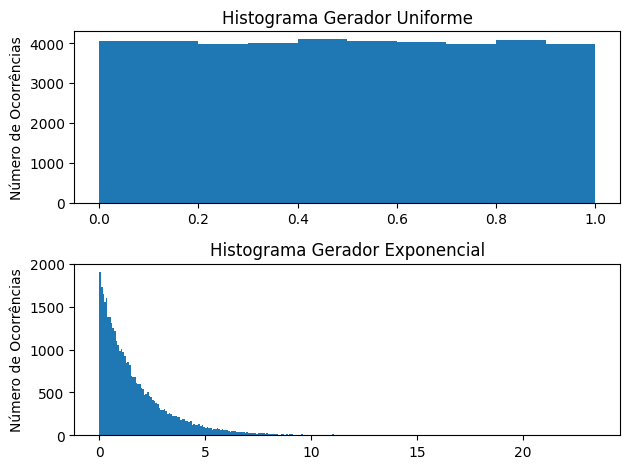

In [15]:
simulator = Simulator(0.5, 0.8, arrival_rate, 0.6)
simulator.run(simulation_time)
#plt.style.use('seaborn')

plt.subplot(2, 1, 1)
plt.title('Histograma Gerador Uniforme')

plt.ylabel('Número de Ocorrências')

plt.hist(uniforme)

plt.subplot(2, 1, 2)
plt.title('Histograma Gerador Exponencial')
plt.ylabel('Número de Ocorrências')
plt.hist(exp, bins=300)
plt.tight_layout()

plt.show()
